# Лабораторная работа №3

## Градиентный бустинг деревьев решений

Рассмотрим качество работы алгоритмов градиентного бустинга деревьев решений в зависимости от настраиваемых гиперпараметров

В качестве датасета будем использовать данные из [соревнования на Kaggle](https://www.kaggle.com/competitions/playground-series-s4e10/overview) (определение выгодности предоставления кредита по данным из заявки на его получение)

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score

In [3]:
from imblearn.over_sampling import RandomOverSampler

In [4]:
from core.visualiztion import *
from core.evaluation import *
from core.training import *
from core.reports.ModelInfo import *
from core.reports.TrainingReport import *

## Загрузка и первичный анализ данных

In [5]:
data_path = 'data'

In [6]:
train_df = pd.read_csv(f"{data_path}/train.csv", index_col=0)
train_df.sample(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
23558,32,55000,MORTGAGE,7.0,DEBTCONSOLIDATION,A,4000,5.42,0.07,N,9,0
58242,53,90000,MORTGAGE,7.0,PERSONAL,A,5600,8.63,0.06,N,30,0
8553,22,33996,RENT,6.0,MEDICAL,D,10000,15.95,0.29,N,4,1
11528,23,76654,RENT,3.0,VENTURE,C,20000,13.79,0.26,Y,3,1
39938,39,52000,MORTGAGE,3.0,VENTURE,C,16000,12.99,0.31,Y,11,0
45107,27,48000,MORTGAGE,7.0,VENTURE,A,4500,5.42,0.09,N,8,0
31735,23,62000,RENT,0.0,EDUCATION,C,12000,12.73,0.19,N,3,0
57797,30,58000,RENT,7.0,EDUCATION,C,10000,13.92,0.17,Y,8,0
238,23,55000,RENT,3.0,PERSONAL,C,12000,13.49,0.22,N,4,0


Посмотрим на размер датасета и типы данных столбцов

In [7]:
train_df.shape

(58645, 12)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


Датасет состоит преимущественно из числовых столбцов, также имеется ряд строковых. Рассмотрим числовые характеристики каждых чтобы выделить возможные категориальные столбцы

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106979,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


Здесь можно заметить, что большинство измерений лежит примерно в одном диапазоне, исключениями являются размер кредита и доход получателя, отличающиеся от остальных значений на порядки. Однако поскольку градиентный бустинг устойчив к разнице в масштабах данных - операцию масштабирования проводить не будем

In [10]:
train_df.select_dtypes(include=["object"]).describe()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58645,58645,58645,58645
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49943


По числу уникальных значений у строковых измерений можно сделать вывод, что все они являются категориями, поэтому в дальнейшем мы применим к ним различные операции кодирования

Построим круговые диаграммы для данных категорий и для целевой переменной, чтобы посмотреть на распределение данных по этим измерениям

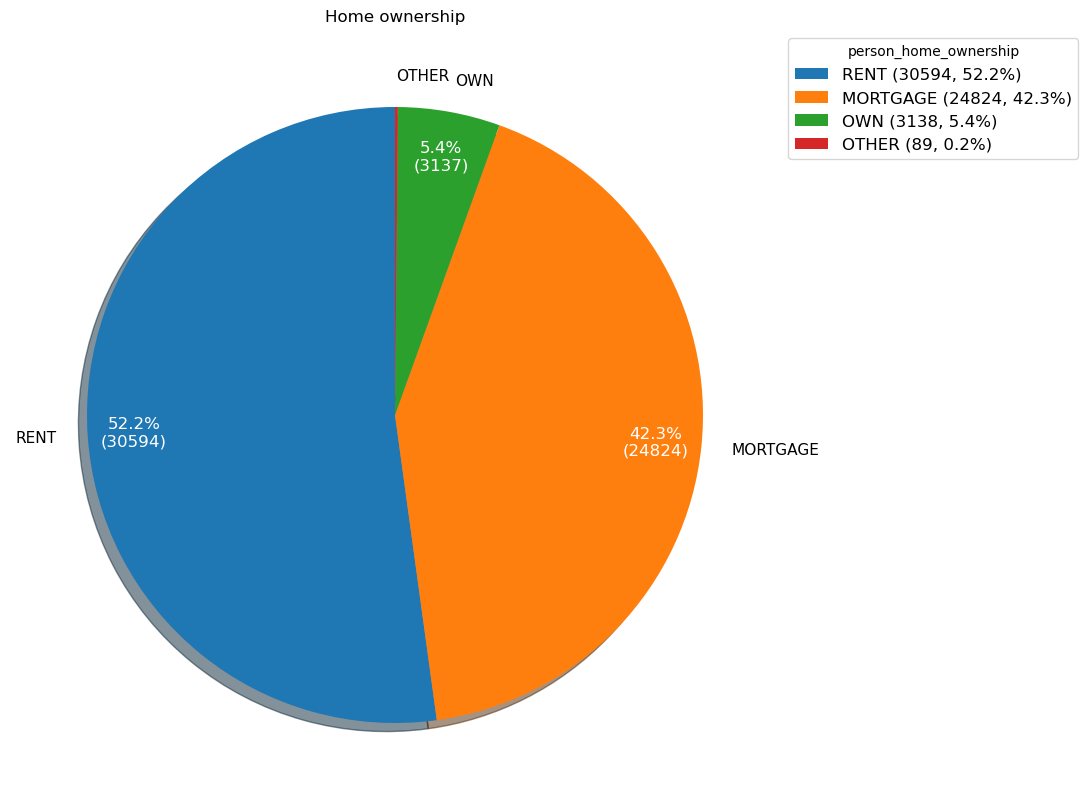

In [11]:
plot_pie_chart(data=train_df, column='person_home_ownership', title='Home ownership')

На диаграмме можно заметить, что подавляющее число кредитополучателей снимают жилье, либо выплачивают ипотеку. Около 5% имеют собственное жилье и об исчезающе малом проценте кредитополучателей (касательно их жилья) информации нет

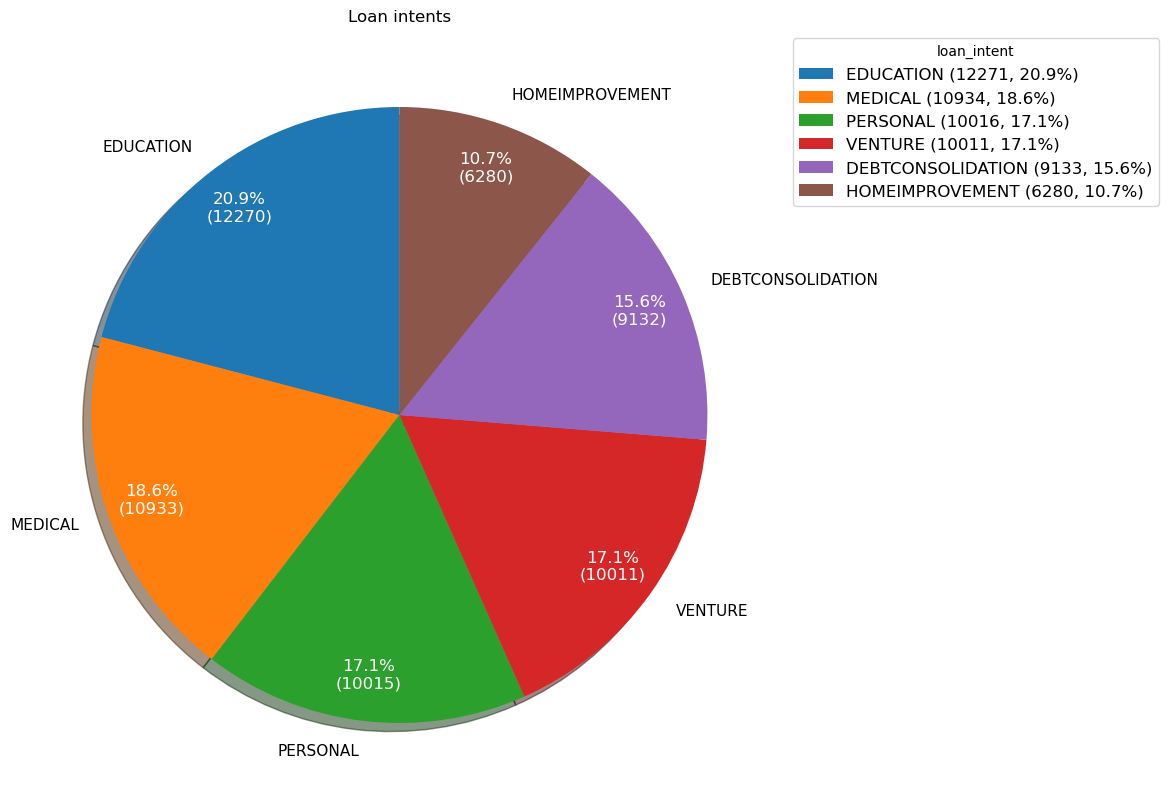

In [12]:
plot_pie_chart(data=train_df, column='loan_intent', title='Loan intents')

Цели, для которых берутся кредиты, распределены примерно равномерно. Наибольшее число кредитов берется на образование, меньшая их часть - на улучшение жилища 

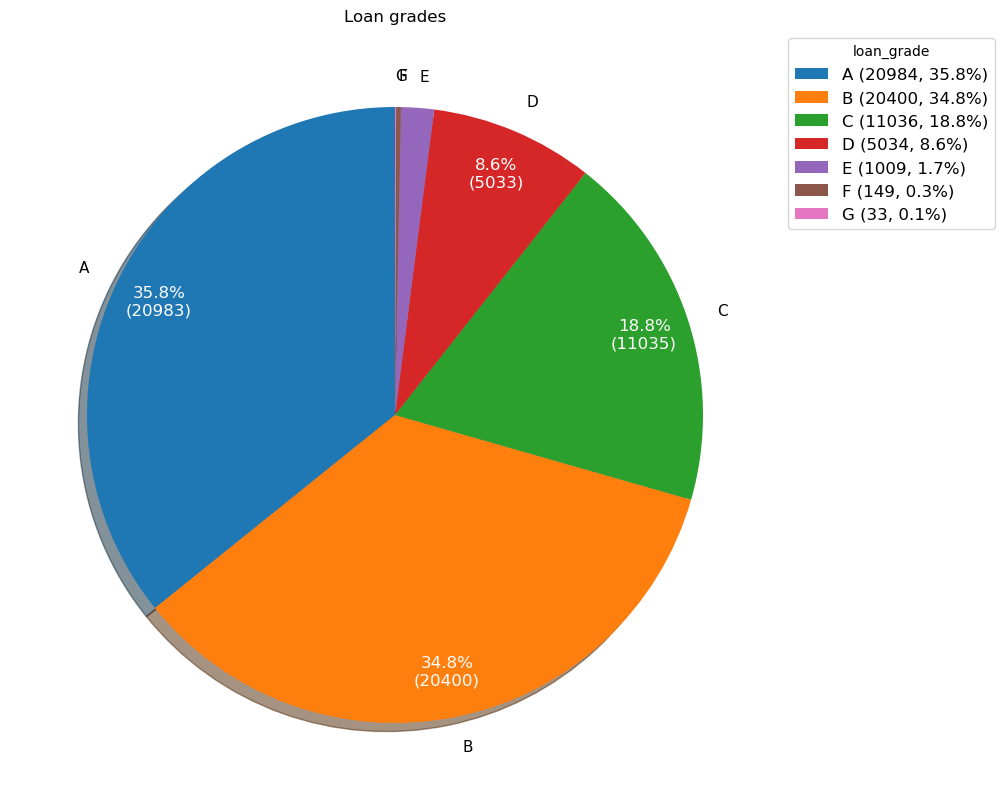

In [13]:
plot_pie_chart(data=train_df, column='loan_grade', title='Loan grades')

Большинство оценок риска для кредитов являются минимальными, оценок, говорящих о большем риске при выдаче кредита, становится все меньше и меньше. Самую "высокую" рискованность имеет 0.1% всех заявок на кредит

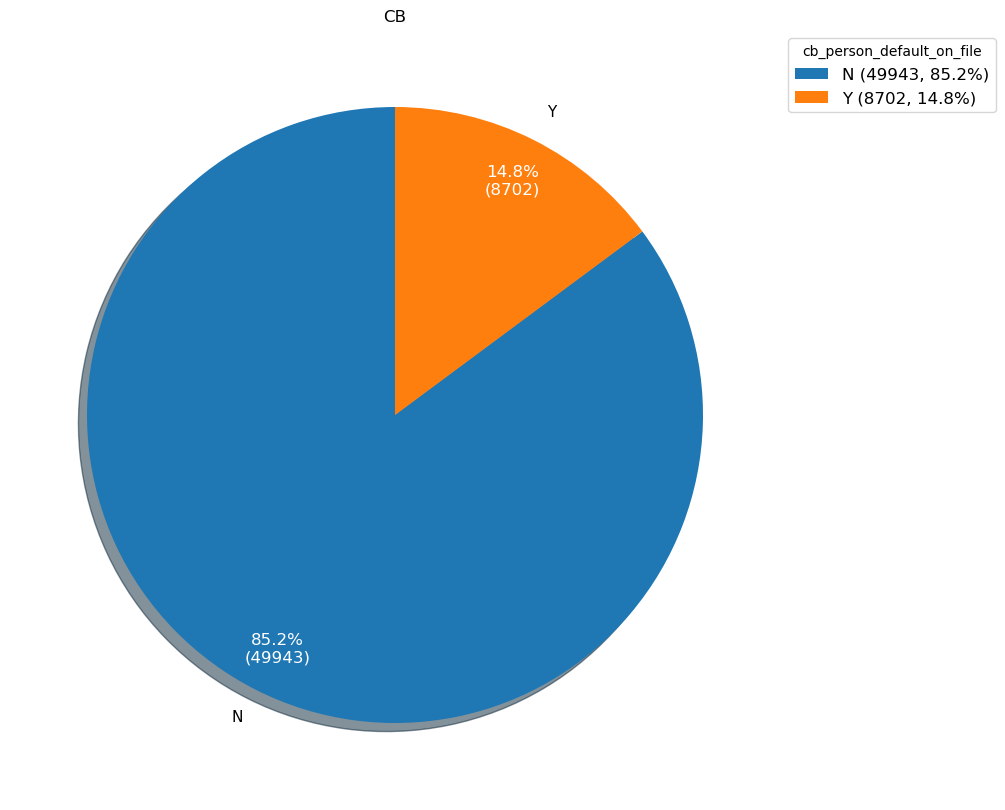

In [14]:
plot_pie_chart(data=train_df, column='cb_person_default_on_file', title='CB')

Подавляющее большинство кредитополучателей не зарегистрированы в базе данных кредитных дефолтов, то есть не имеют просрочек по кредитам

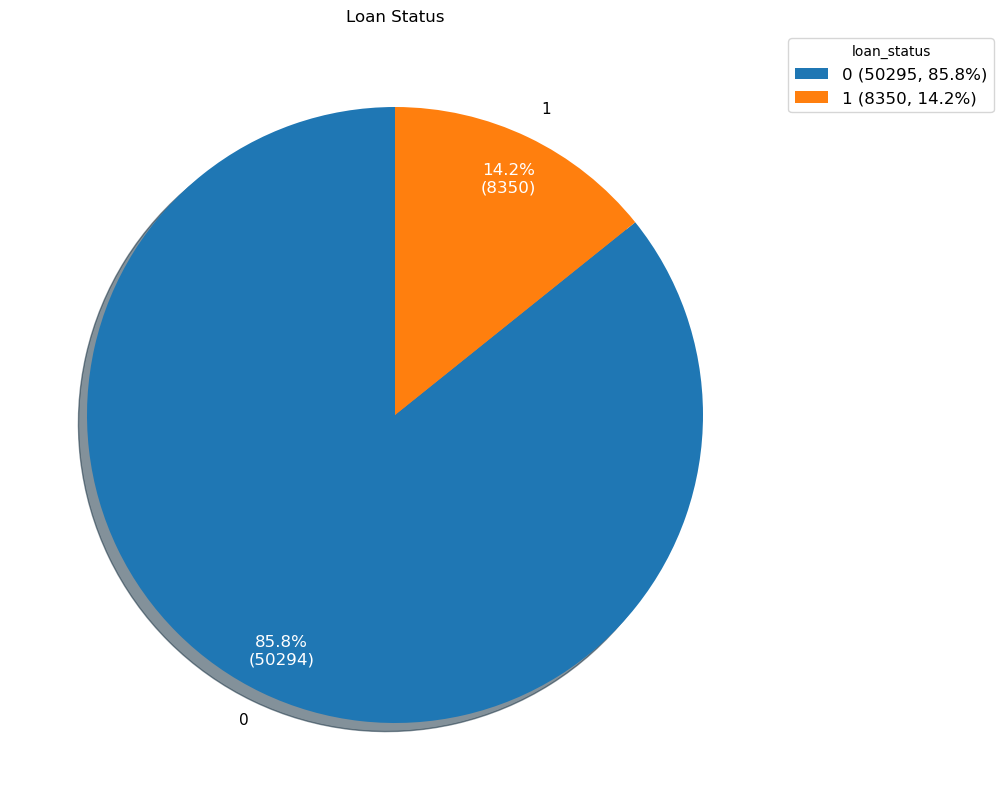

In [15]:
plot_pie_chart(data=train_df, column='loan_status', title='Loan Status')

Целевая переменная (статус кредита) в подавляющем большинстве случаев имеет негативное значение, что говорит нам о том, что необходимо использовать выравнивающие стратегии сэмплирования и/или использовать метрики, устойчивые к скошенному распределению (например `f1_score`)

Поскольку перед нами стоит задача бинарной классификации - мы можем использовать классический `f1_score`. Кроме того, мы будем предсказывать вероятностное распределение классов и оценивать его качество (по вероятности положительного класса) с помощью `roc_auc_score`, что позволяет решать практическую задачу более гибко (использовать threshold'ы), а также продиктовано требованиями соревнования

Посмотрим на корреляции между числовыми переменными

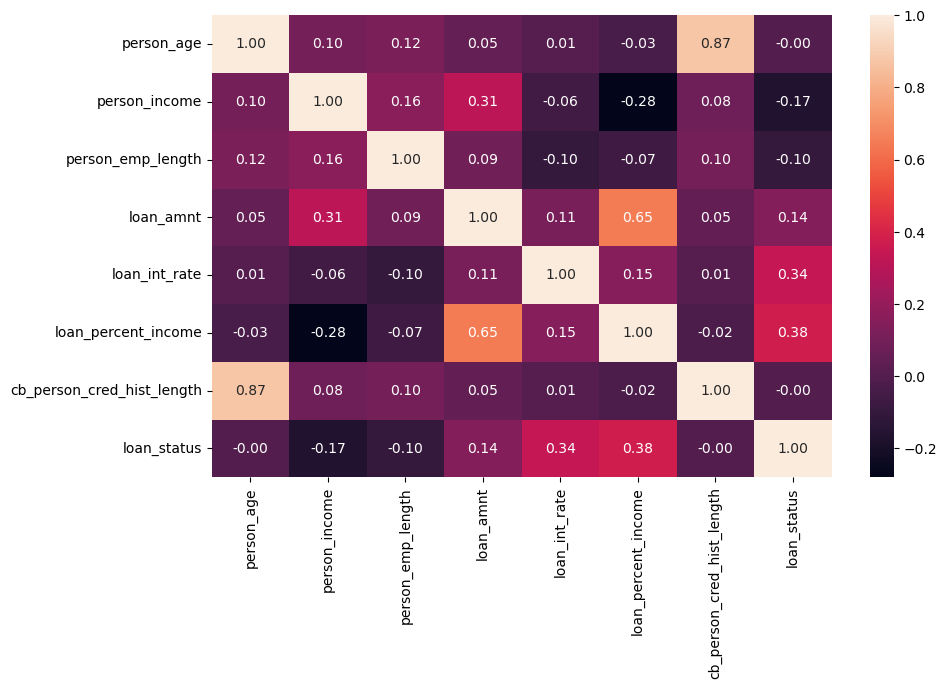

In [16]:
correlations = train_df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.show()

Большинство корреляций являются слабыми, исключением является связь между размером кредита и отношением суммы кредита к доходу заемщика в процентах, что логично

Поскольку максимальная корреляция не превосходит `0.8` и, кроме того, градиентный бустинг достаточно устойчив к линейным зависимостям между переменными - мы не будем проводить дополнительную обработку данных, направленную на уменьшение коэффициентов корреляции между переменными

## Подготовка данных для обучения модели

Создадим копию исходного датасета

In [17]:
train_df_prepared = train_df.copy()
train_df_prepared.sample(10)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
41086,26,175000,RENT,0.0,EDUCATION,A,15000,7.49,0.09,N,3,0
34799,30,50000,OWN,0.0,VENTURE,B,6400,12.21,0.13,N,5,0
27423,28,60000,OWN,4.0,EDUCATION,B,12000,12.18,0.20,N,7,0
54431,23,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.62,0.15,N,3,0
439,30,38000,OWN,0.0,MEDICAL,C,13250,12.87,0.36,N,8,0
16657,22,56000,RENT,2.0,DEBTCONSOLIDATION,B,14000,10.65,0.25,N,3,0
14908,26,75000,RENT,0.0,VENTURE,C,11000,13.49,0.15,Y,3,0
35776,31,30000,MORTGAGE,3.0,PERSONAL,A,3600,5.99,0.12,N,5,0
56282,27,50000,MORTGAGE,0.0,HOMEIMPROVEMENT,A,10000,8.94,0.20,N,9,0


Способ владения недвижимостью и цель заема не имеют иерархического порядка следования, потому для их кодировки применим `one_hot_encoding`

In [18]:
one_hot_columns = ['person_home_ownership', 'loan_intent']
train_df_prepared = pd.get_dummies(train_df_prepared, columns=one_hot_columns, drop_first=False)
train_df_prepared.sample(10)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
id,,,,,,,,,,,,,,,,,,,,
22244,22,30000,0.0,B,8000,11.71,0.27,N,3,0,False,False,False,True,False,True,False,False,False,False
9185,23,60000,4.0,A,13500,6.92,0.23,N,4,0,True,False,False,False,False,True,False,False,False,False
6865,21,49000,2.0,D,6000,15.31,0.12,Y,4,1,False,False,False,True,False,False,False,True,False,False
19089,26,53400,3.0,B,4000,9.99,0.07,N,2,0,True,False,False,False,False,False,False,False,True,False
16712,25,66000,9.0,B,25000,11.11,0.38,N,3,1,False,False,False,True,False,False,False,True,False,False
3558,35,30000,8.0,B,7000,12.69,0.23,N,5,0,False,False,False,True,False,False,False,False,False,True
4215,42,48000,0.0,A,6000,7.74,0.13,N,15,0,True,False,False,False,True,False,False,False,False,False
39351,25,96300,0.0,A,18000,7.88,0.19,N,4,0,True,False,False,False,False,True,False,False,False,False
48138,37,100000,11.0,A,6000,7.88,0.06,N,16,0,True,False,False,False,False,False,False,False,True,False


Кредитный риск, выраженный в категориях от A до G имеет иерархический порядок следования, возможный кредит с риском A это не одно и то же, что кредит с риском G, поэтому для кодировки данной переменной применим `ordinal encoding`

Выделим возможные значения категорий и отсортируем их

In [19]:
grades = [np.sort(train_df_prepared['loan_grade'].unique()).tolist()]
grades

[['A', 'B', 'C', 'D', 'E', 'F', 'G']]

Подготовим кодировщик и закодируем данную переменную

In [20]:
ordinal_encoder = OrdinalEncoder(categories=grades)
ordinal_encoder.get_params()

{'categories': [['A', 'B', 'C', 'D', 'E', 'F', 'G']],
 'dtype': numpy.float64,
 'encoded_missing_value': nan,
 'handle_unknown': 'error',
 'max_categories': None,
 'min_frequency': None,
 'unknown_value': None}

In [21]:
train_df_prepared['loan_grade_encoded'] = ordinal_encoder.fit_transform(train_df_prepared[['loan_grade']])
train_df_prepared = train_df_prepared.drop('loan_grade', axis=1)
train_df_prepared.sample(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_encoded
id,,,,,,,,,,,,,,,,,,,,
46845,26,43000,3.0,10000,9.91,0.23,N,4,0,False,False,False,True,False,True,False,False,False,False,1.0
26532,27,90000,0.0,15000,15.70,0.17,Y,5,0,True,False,False,False,False,False,False,False,False,True,3.0
17231,25,33000,4.0,4000,8.94,0.12,N,2,0,False,False,False,True,False,False,False,False,False,True,0.0
23601,30,65000,7.0,10000,12.69,0.15,N,7,0,False,False,False,True,True,False,False,False,False,False,1.0
21164,28,36000,12.0,11200,19.42,0.31,Y,7,1,False,False,False,True,False,False,False,False,False,True,4.0
38531,38,60000,5.0,4000,9.99,0.07,N,13,0,True,False,False,False,False,False,False,False,True,False,1.0
15142,33,48000,13.0,8000,16.49,0.16,N,5,0,False,False,False,True,False,False,False,True,False,False,3.0
18756,27,82500,0.0,9000,7.49,0.11,N,7,0,False,False,False,True,False,False,False,False,False,True,0.0
43333,23,65000,7.0,6000,7.49,0.09,N,2,0,True,False,False,False,True,False,False,False,False,False,0.0


Для кодирования нахождения заемщика в базе данных кредитных дефолтов используем бинарное кодирование

In [22]:
train_df_prepared['cb_person_default_on_file_encoded'] = train_df_prepared['cb_person_default_on_file']\
    .map({'N': False, 'Y': True})
train_df_prepared = train_df_prepared.drop('cb_person_default_on_file', axis=1)
train_df_prepared.sample(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_encoded,cb_person_default_on_file_encoded
id,,,,,,,,,,,,,,,,,,,,
34866,22,60000,2.0,15000,10.25,0.25,3,0,False,False,False,True,True,False,False,False,False,False,1.0,False
31146,25,125000,7.0,12000,13.92,0.10,3,0,False,False,False,True,False,False,False,True,False,False,2.0,False
46655,27,50000,2.0,8000,9.99,0.16,5,0,False,False,False,True,False,True,False,False,False,False,1.0,False
15871,32,55000,7.0,8000,8.49,0.15,10,0,True,False,False,False,False,False,False,False,True,False,0.0,False
21448,35,32000,4.0,1400,13.35,0.05,6,0,False,False,False,True,False,False,False,True,False,False,2.0,False
56175,22,30000,0.0,15000,12.53,0.50,2,1,False,False,False,True,False,False,False,False,False,True,2.0,False
11613,29,84996,13.0,1800,8.49,0.02,8,0,True,False,False,False,False,False,False,False,False,True,0.0,False
13375,27,24000,0.0,6000,9.63,0.25,10,0,False,False,False,True,False,False,False,False,False,True,0.0,False
41508,25,30000,0.0,5200,15.96,0.17,3,0,False,False,False,True,False,False,False,False,False,True,2.0,False


Вновь посмотрим на типы данных

In [23]:
train_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         58645 non-null  int64  
 1   person_income                      58645 non-null  int64  
 2   person_emp_length                  58645 non-null  float64
 3   loan_amnt                          58645 non-null  int64  
 4   loan_int_rate                      58645 non-null  float64
 5   loan_percent_income                58645 non-null  float64
 6   cb_person_cred_hist_length         58645 non-null  int64  
 7   loan_status                        58645 non-null  int64  
 8   person_home_ownership_MORTGAGE     58645 non-null  bool   
 9   person_home_ownership_OTHER        58645 non-null  bool   
 10  person_home_ownership_OWN          58645 non-null  bool   
 11  person_home_ownership_RENT         58645 non-null  bool   


Как видно, все переменные имеют либо числовой, либо булевый тип данных, что говорит о возможности построения классификатора на имеющихся данных

Выделим признаки и целевую переменную

In [24]:
X = train_df_prepared.drop(columns=['loan_status'])
y = train_df_prepared['loan_status']

Еще раз посмотрим на распределение целевых меток

In [25]:
y.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

Мы видим скошенное распределение, с которым необходимо что-то делать. Воспользуемся технологией оверсэмплинга, клонирующей случайные экземпляры минорного класса до тех пор, пока количество экземпляров классов не сравняется

In [26]:
ros = RandomOverSampler()
X_oversampled, y_oversampled = ros.fit_resample(X, y)

In [27]:
y_oversampled.value_counts()

loan_status
0    50295
1    50295
Name: count, dtype: int64

Теперь классы распределены равномерно

## Обучение классификатора

Разделим данные на тренировочную и тестовую выборки в соотношении 80/20

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state=42)

В качестве эксперимента мы будем искать оптимальную комбинацию параметров `n_estimators`, `learning_rate`, `loss` и `subsample`. Лучшую модель будем выбирать по `roc_auc_score` на тестовой подвыборке

Укажем перебираемые значения для поиска оптимальной комбинации параметров

In [29]:
trees_numbers = [1000]
learning_rates = [0.25]
losses = ['log_loss']
subsample_sizes = [1, 0.65]

Инициализируем процесс тренировки и выполним ее

In [30]:
trainer = GBModelTrainer(
    train_x=X_train, 
    train_y=y_train, 
    test_x=X_test, 
    test_y=y_test, 
    trees_numbers=trees_numbers, 
    learning_rates=learning_rates, 
    losses=losses, 
    subsample_sizes=subsample_sizes, 
    random_state=42
)

In [ ]:
%%time
training_report, best_classifier = trainer.train()

После 44-х минут обучения получим следующий отчет

In [ ]:
training_report.to_frame()

Лучший результат показали модели, имеющие 1000 деревьев (наибольшее значение из анализируемых), самую высокую скорость обучения, функцию потерь log_loss. Доля обучающей выборки для обучения конкретного решающего дерева большой роли не сыграла, однако меньшие значения показывают чуть лучший результат

Построим графики изменения f1-меры, ROC AUC score и значения функции потерь в зависимости от итерации для каждой из комбинаций параметров

In [ ]:
for model_info in training_report:
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_info.f1_score_history) + 1), model_info.f1_score_history, label="Изменение F1-меры")
    plt.plot(np.arange(1, len(model_info.roc_auc_history) + 1), model_info.roc_auc_history, label="Изменение ROC AUC")
    plt.xlabel("Число итераций (деревьев)")
    plt.title(f"{model_info.model_name} (метрики качества)")
    plt.legend()
    plt.grid()
   
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(model_info.loss_history) + 1), model_info.loss_history, label="Изменение функции потерь")
    plt.xlabel("Число итераций (деревьев)")
    plt.title(f"{model_info.model_name} (функция потерь)")
    plt.legend()
    plt.grid()
    plt.show()

Глобально по графикам можно заметить, что в самом начале обучения (маленькое число деревьев) наблюдается стремительное улучшение качества работы модели на тестовой выборке и падение значения функции потерь. Далее, примерно после 100-200 итераций, скорость изменения графиков уменьшается и с увеличением числа итераций они приближаются к плато

Также можно заметить, что большинство графиков моделей с subsample равным 1 плавные, в то время как при sumbample равном 0.65 наблюдаются небольшие колебания примерно после 100-й итерации

Чем выше learning_rate модели, тем быстрее она доходит до состояния плато как по качеству прогнозов на тестовой выборке, так и по изменению функции потерь. Однако можно заметить, что ни на одном из графиков не наблюдалось полного плато, а значит гипотетическое увеличение размера модели может показать лучший результат

Выбор функции потерь изменяет историю обучения не так сильно, как остальные гиперпараметры, однако стоит отметить, что немного лучший результат показывают модели, использующие log_loss в качестве функции потерь

Выделим наилучший классификатор (показавший наибольший ROC AUC score на тестовой выборке) и проанализируем его

In [ ]:
best_classifier.get_params()

Построим на матрицы ошибок модели на тренировочной и тестовой выборках

In [ ]:
best_model_train_predictions = best_classifier.predict(X_train)
plot_confusion_matrix(y_train, best_model_train_predictions, title="Матрица ошибок на тренировочной выборке")

In [ ]:
best_model_test_predictions = best_classifier.predict(X_test)
plot_confusion_matrix(y_test, best_model_test_predictions, title="Матрица ошибок на тестовой выборке")

Как видно, модель ошибается достаточно мало раз, ошибки между классами распределены примерно равномерно, что говорит о том, что проблема дисбаланса классов была решена

Сохраним лучший классификатор

In [ ]:
import joblib

In [ ]:
joblib.dump(best_classifier, 'models/best_gb_classifier.joblib')

Протестируем работоспособность сохраненного классификатора

In [ ]:
best_classifier = joblib.load('models/best_gb_classifier.joblib')

In [ ]:
best_model_train_predictions = best_classifier.predict(X_train)
plot_confusion_matrix(y_train, best_model_train_predictions, title="Матрица ошибок на тренировочной выборке")

In [ ]:
best_model_test_predictions = best_classifier.predict(X_test)
plot_confusion_matrix(y_test, best_model_test_predictions, title="Матрица ошибок на тестовой выборке")

Матрицы совпадают с полученными ранее, значит модель сохранилась успешно

Построим гистограмму влияния каждого из признаков на предсказанный ответ для лучшей модели

In [ ]:
features = best_classifier.feature_names_in_
importances = best_classifier.feature_importances_

In [ ]:
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feature_importances_df

In [ ]:
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
feature_importances_df

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')

plt.title('Важность признаков при работе лучшего классификатора', fontsize=14)
plt.xlabel('Важность', fontsize=14)
plt.ylabel('Признак', fontsize=14)

plt.tight_layout()
plt.show()

Наиболее важным оказалось отношение размера кредита к доходу заемщика (что логично, так как это комбинированная метрика), также важными являются категория риска кредита и непосредственный доход заемщика

Интересно, что исчезающе низкую оценку получило нахождение заемщика в базе данных кредитных дефолтов. Низкие оценки для цели кредита и владения недвижимостью можно объяснить разбиением этих признаков на dummy-столбцы

## Прогноз на тестовых данных

Загрузим тестовый датасет и предобработаем его так же, как и тренировочные данные

In [ ]:
test_df = pd.read_csv(f"{data_path}/test.csv", index_col=0)
test_df.sample(10)

In [ ]:
test_df.shape

In [ ]:
test_df = pd.get_dummies(test_df, columns=one_hot_columns, drop_first=False)
test_df.sample(10)

In [ ]:
test_df['loan_grade_encoded'] = ordinal_encoder.fit_transform(test_df[['loan_grade']])
test_df = test_df.drop('loan_grade', axis=1)
test_df.sample(10)

In [ ]:
test_df['cb_person_default_on_file_encoded'] = test_df['cb_person_default_on_file'].map({'N': False, 'Y': True})
test_df = test_df.drop('cb_person_default_on_file', axis=1)
test_df.sample(10)

Выделим вероятности положительного класса для тестовых данных

In [ ]:
predictions = best_classifier.predict_proba(test_df)[:, 1]
predictions

Запишем их вместе с id экземпляра в датафрейм, и сохраним для отправки на Kaggle

In [ ]:
submission_df = pd.DataFrame({'id': test_df.index, 
                           'loan_status': predictions})
submission_df.head(10)

In [ ]:
submission_df.to_csv(f'{data_path}/submission.csv', index=False)

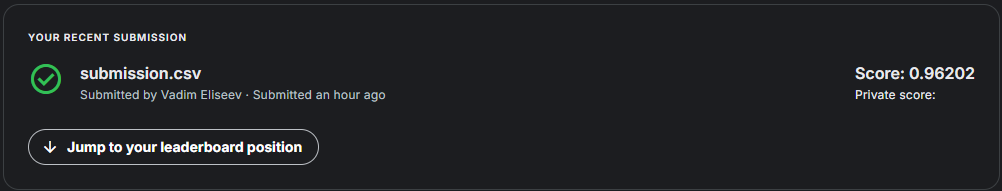

Как видно, натренированный нами классификатор хорошо справился с тестовыми данными, показав ROC AUC score превосходящий 96%